In [49]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from skimage import io
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Data preparation

In [2]:
train_dir='/kaggle/input/labeled-chest-xray-images/chest_xray/train'
test_dir='/kaggle/input/labeled-chest-xray-images/chest_xray/test'

In [3]:
# labeling the images into 3 classes instead of 2
# labels: 0-normal, 1-virus, 2-bacteria

train_labels={"filename":[], "label":[], "type":[], "binary class":[]}
test_labels={"filename":[], "label":[], "type":[], "binary class":[]}

for img_name in os.listdir(train_dir+"/NORMAL"):
    train_labels["filename"].append(img_name)
    train_labels["label"].append(0)
    train_labels["type"].append("normal")
    train_labels["binary class"].append("NORMAL")
    
for img_name in os.listdir(test_dir+"/NORMAL"):
    test_labels["filename"].append(img_name)
    test_labels["label"].append(0)
    test_labels["type"].append("normal")
    test_labels["binary class"].append("NORMAL")
    
for img_name in os.listdir(train_dir+"/PNEUMONIA"):
    if img_name[:1]=="V":
        train_labels["filename"].append(img_name)
        train_labels["label"].append(1)
        train_labels["type"].append("virus")
        train_labels["binary class"].append("PNEUMONIA")
    else:
        train_labels["filename"].append(img_name)
        train_labels["label"].append(2)
        train_labels["type"].append("bacteria")
        train_labels["binary class"].append("PNEUMONIA")
        
for img_name in os.listdir(test_dir+"/PNEUMONIA"):
    if img_name[:1]=="V":
        test_labels["filename"].append(img_name)
        test_labels["label"].append(1)
        test_labels["type"].append("virus")
        test_labels["binary class"].append("PNEUMONIA")
    else:
        test_labels["filename"].append(img_name)
        test_labels["label"].append(2)
        test_labels["type"].append("bacteria")
        test_labels["binary class"].append("PNEUMONIA")
        

train_data=pd.DataFrame.from_dict(train_labels)
train_data =train_data.assign(img_path=lambda x: train_dir +"/"+ x['binary class'] +"/"+ x['filename'])
#train_data.drop(labels=["binary class"], axis=1, inplace=True)
train_data.to_csv("train_labels.csv", index=False)

test_data=pd.DataFrame.from_dict(test_labels)
test_data =test_data.assign(img_path=lambda x: test_dir +"/"+ x['binary class'] +"/"+ x['filename'])
#test_data.drop(labels=["binary class"], axis=1, inplace=True)
test_data.to_csv("test_labels.csv", index=False)

In [4]:
train_data

,filename,label,type,binary class,img_path
0,NORMAL-705219-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
1,NORMAL-9031828-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
2,NORMAL-9211217-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
3,NORMAL-8050432-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
4,NORMAL-6897353-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
...,...,...,...,...,...
5227,BACTERIA-3852742-0001.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
5228,BACTERIA-4313165-0003.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
5229,BACTERIA-6518955-0001.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
5230,BACTERIA-3076396-0001.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...


In [5]:
label_count=train_data.groupby(by="type", as_index=False).count().sort_values(by="filename", ascending=False).reset_index(drop=True)
label_count_test=test_data.groupby(by="type", as_index=False).count().sort_values(by="filename", ascending=False).reset_index(drop=True)
print("Label distribution is train data: \n", label_count[["type", "filename"]], "\n")
print("Label distribution is test data: \n", label_count_test[["type", "filename"]])

Label distribution is train data: 
        type  filename
0  bacteria      2538
1    normal      1349
2     virus      1345 

Label distribution is test data: 
        type  filename
0  bacteria       242
1    normal       234
2     virus       148


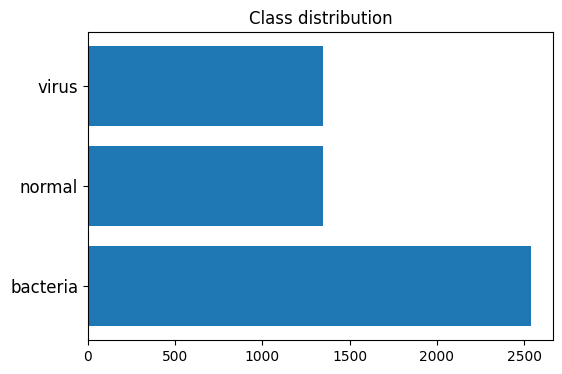

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax=plt.barh(label_count["type"], label_count["filename"])
plt.title("Class distribution")
plt.xticks(fontsize = 10) 
plt.yticks(["bacteria", "normal", "virus"], fontsize = 12) 
plt.show()

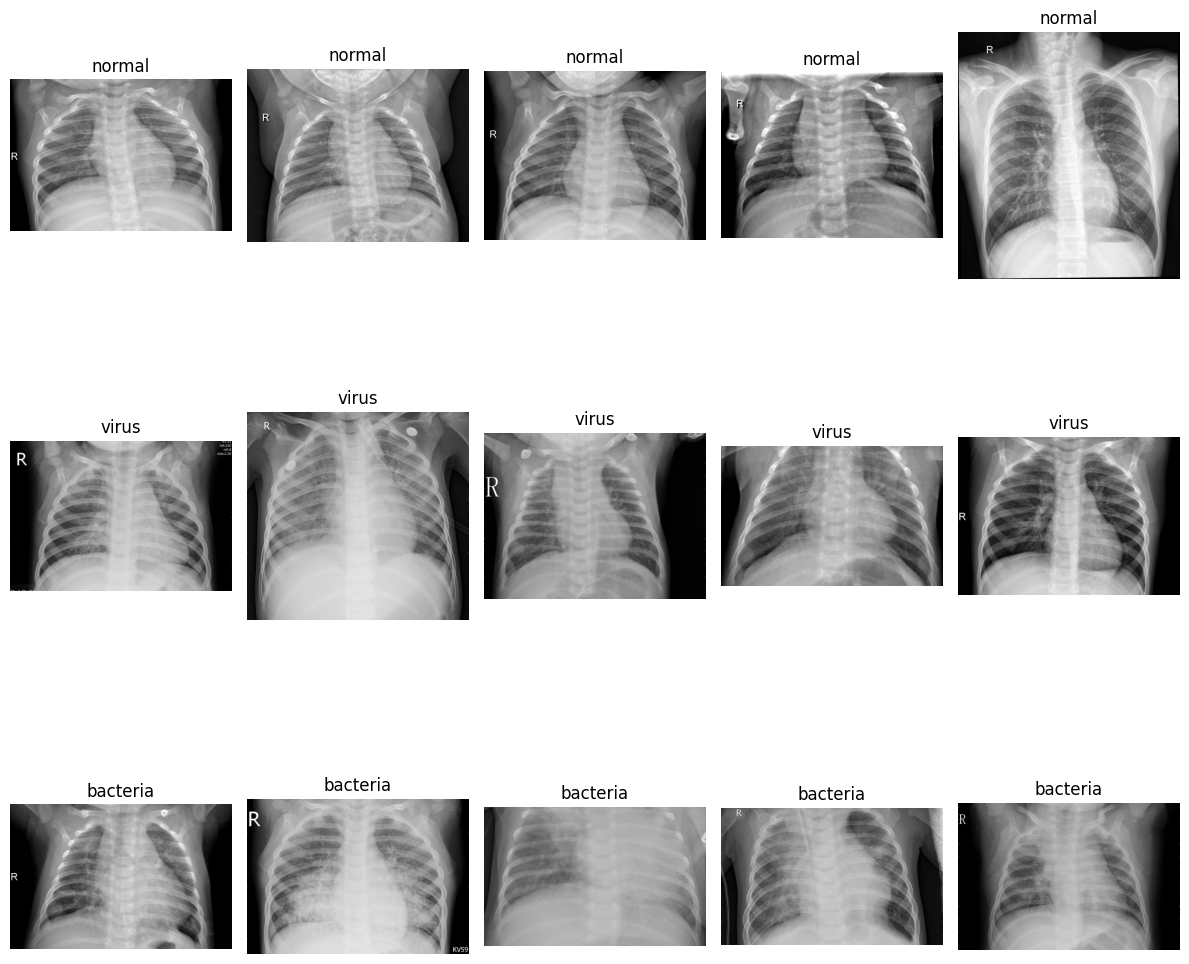

In [7]:
types = train_data['type'].unique()
num_types = len(types)
num_images_per_type = 5

fig, axes = plt.subplots(num_types, num_images_per_type, figsize=(12, 4 * num_types))

for i, type_ in enumerate(types):
    subset = train_data[train_data['type'] == type_].head(num_images_per_type)
    
    for j, (idx, row) in enumerate(subset.iterrows()):
        img_path = row['img_path']
        
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img, cmap="gray")
        axes[i, j].set_title(f"{row['type']}")
        axes[i, j].axis('off')
        
        #print(img.size)

plt.tight_layout()
plt.show()

# Dataset classes

In [8]:
class Train_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        img_path=self.data.iloc[index, 4]
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.data.iloc[index, 1]))


        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [9]:
class Test_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.data=pd.read_csv(csv_file)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        img_path=self.data.iloc[index, 4]
        image = io.imread(img_path)
     
        if self.transform:
            image = self.transform(image)

        return image

In [10]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Grayscale(3),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])


In [11]:
num_classes = 3
learning_rate = 1e-3
batch_size = 128
num_epochs = 5
lr_ratio=0.005

In [12]:
dataset = Train_dataset('/kaggle/working/train_labels.csv', transform=train_transform)
train_set_size = int(len(dataset) * 0.8)
print("Train set length: ", train_set_size)
valid_set_size = len(dataset) - train_set_size
print("Validation set length: ", valid_set_size)
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

test_data = Test_dataset('/kaggle/working/test_labels.csv', transform=test_transform)
print("Test set length: ",len(test_data))
test_loader = DataLoader(test_data, batch_size=batch_size)

Train set length:  4185
Validation set length:  1047
Test set length:  624


# Functions for training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device")
print(device)

Device
cuda


In [14]:
# save checkpoint
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    torch.save(state, filename)

# load checkpint
def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    #scheduler = checkpoint['scheduler']

In [15]:
def plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list):
    epochs = len(training_accuracy_list)
    x = np.arange(1, epochs + 1)

    training_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_accuracy_list]
    training_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_loss_list]
    validation_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_accuracy_list]
    best_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_loss_list]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(x, training_accuracy_list, label='Training Accuracy', color='blue')
    axes[1].plot(x, training_loss_list, label='Training Loss', color='orange')
    axes[0].plot(x, validation_accuracy_list, label='Validation Accuracy', color='green')
    axes[1].plot(x, best_loss_list, label='Validation Loss', color='red')

    fig.suptitle('Model Evaluation Metrics')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    axes[1].grid(True)
    plt.show()

In [16]:
def traindata(device, model, epochs, optimizer, scheduler, loss_function, train_loader, valid_loader, filename):
    # Early stopping
    best_loss = 100
    patience = 5
    trigger_times = 0

    # Lists to store data for plotting
    training_accuracy_list = []
    training_loss_list = []
    best_loss_list = []
    validation_accuracy_list = []
    validation_loss_list = []

    for epoch in range(1, epochs+1):
        model.train()
        correct = 0
        loss_total = 0
        for data in train_loader:
            input = data[0].to(device)
            label = data[1].to(device)

            optimizer.zero_grad()

            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
            loss.backward()
            optimizer.step()
            scheduler.step()

        training_accuracy = correct/len(train_loader.sampler)
        training_loss = loss_total/len(train_loader)

        print('{}. epoch'.format(epoch))
        

         # Early stopping
        current_loss, validation_accuracy = validation(model, device, valid_loader, loss_function)
        print('Training accuracy: {} Training loss: {} \nValidation accuracy: {} Validation loss: {}'.format(training_accuracy, training_loss, validation_accuracy, current_loss))

        # Append values to lists for plotting
        training_accuracy_list.append(training_accuracy)
        training_loss_list.append(training_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(current_loss)
        best_loss_list.append(best_loss)

        if current_loss > best_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping! Start to test process.')
                break
        else:
            trigger_times = 0
            save_checkpoint(checkpoint, filename)
            best_loss = current_loss

    # Plot the results
    plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list)

    return model

In [17]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    correct = 0
    
    with torch.no_grad():
        for data in valid_loader:
            input = data[0].to(device)
            label = data[1].to(device)
            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
        validation_accuracy = correct/len(valid_loader.sampler)
    return loss_total / len(valid_loader), validation_accuracy

In [18]:
def test(device, model, test_loader, loss_function):
    model.eval()
    predictions = pd.DataFrame()
    with torch.no_grad():
        for data in test_loader:
            input = data.to(device)
            output = model(input)
            m = nn.Softmax(dim=1)
            res = m(output)
            predictions = pd.concat([predictions, pd.DataFrame(torch.Tensor.cpu(res).numpy(), columns = [0, 1, 2])], ignore_index=True)
        return (predictions)

# Baseline model

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
       
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 56 * 56)          
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



model_simple = SimpleCNN(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_simple = model_simple.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_simple.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.39593788981437683 Training loss: 1.978514476255937 
Validation accuracy: 0.46895891427993774 Validation loss: 1.0176486902766757
2. epoch
Training accuracy: 0.6413381099700928 Training loss: 0.8008004065715906 
Validation accuracy: 0.7354345917701721 Validation loss: 0.6399197280406952
3. epoch
Training accuracy: 0.7670251131057739 Training loss: 0.5324917751731295 
Validation accuracy: 0.7736389636993408 Validation loss: 0.5240446428457896
4. epoch
Training accuracy: 0.7727598547935486 Training loss: 0.5198393003507094 
Validation accuracy: 0.6895893216133118 Validation loss: 0.6393146912256876
5. epoch
Training accuracy: 0.781839907169342 Training loss: 0.5058741641767097 
Validation accuracy: 0.7936962842941284 Validation loss: 0.4867979817920261


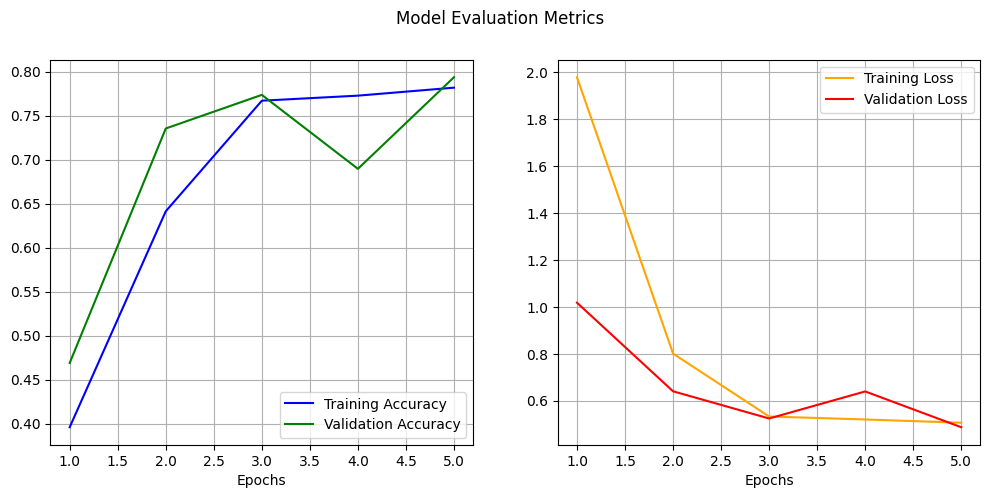

In [21]:
baseline = traindata(device, model_simple, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "simple_checkpoint.pth.tar")

In [24]:
load_checkpoint(torch.load("simple_checkpoint.pth.tar"), model_simple, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1307128653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("simple_checkpoint.pth.tar"), model_simple, optimizer)


In [47]:
df = test(device, baseline, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"], columns=["true_label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('baseline.csv', index=False)
df

,0,1,2,true_label,pred
0,0.652084,0.082668,0.265248,0,0
1,0.658476,0.164481,0.177043,0,0
2,0.979524,0.004663,0.015813,0,0
3,0.669858,0.257837,0.072305,0,0
4,0.257516,0.206110,0.536374,0,2
...,...,...,...,...,...
619,0.114444,0.083789,0.801766,2,2
620,0.000544,0.034520,0.964936,2,2
621,0.001240,0.188171,0.810590,1,2
622,0.045618,0.521126,0.433256,1,1


In [46]:
print("Test accuracy is: ", accuracy_score(df["true_label"], df["pred"]))

Test accuracy is:  0.7756410256410257


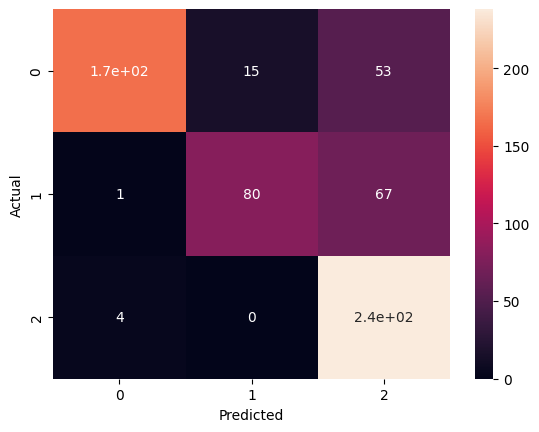

In [55]:
conf_matrix = confusion_matrix(df["true_label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()